## Goal: Model the defect balance over time and predict date recall will be completed

In [39]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [40]:
#starting population of tires that need to be replaced at t=0
# 126,707: TACOM Bi-Weekly SOUM Update Jan 25 2019 -- Daily Status Report cell C50
# 150,868: Sunset Date Analysis2 cell N11 (all tires from 2015-2018)
# 387,272: FY18 total densities of fwics 0077,0130,0133,2002 *4 (max time it would take to get all FY18 tires out of system)
startDefectBalance = 126707

In [41]:
#when replacements started taking place (FY18 Q3 start)
startDate = "4/1/2018"

In [42]:
#set monthly max capacity to 12k, calculate avg daily
monthlyCapacity = -12000
avgDailyCapacity = monthlyCapacity/30.42

In [43]:
#requirements tracker data from Brandi
df = pd.read_csv('Copy of BrandiData.csv',usecols=['Fill Date','Qty'])
print('Requirements Tracker')
df.head(n=10)

Requirements Tracker


,Fill Date,Qty
0,5/31/2018,849
1,5/31/2018,265
2,6/6/2018,337
3,6/11/2018,166
4,6/13/2018,15
5,6/13/2018,88
6,6/13/2018,49
7,6/13/2018,25
8,6/14/2018,500
9,6/15/2018,500


In [44]:
#data processing to get dates to dateDelta and Qty to a cumulative defect balance
df.Qty = df.Qty*-1
dfStart = pd.DataFrame({'Fill Date':startDate,'Qty':startDefectBalance,'ACOM':''},index=[999])
df = pd.concat([df,dfStart])#.sort_values(['Fill Date'],ascending=True)
startDate = datetime.datetime(2018, 4, 1)
df['Fill Date'] =  pd.to_datetime(df['Fill Date'])
df =df.set_index(['Fill Date'])

def removeDays(x):
    x['dateDelta'] = x['dateDelta'].days
    return x

#create new date starting from t=0
df['tvalue'] = df.index
df['dateDelta'] = df['tvalue']-startDate
df = df.apply(lambda x: removeDays(x),axis=1)
df = df.sort_values(['tvalue'],ascending=True)

#roll up orders to the daily level
df = df.groupby('dateDelta').sum()

#get current balance of defective tires
df['balance'] = df.Qty.cumsum()
df = df[['balance']]

df = df.reset_index()
print('Defect Balance Over Time')
df.head(n=10)

Defect Balance Over Time


,dateDelta,balance
0,0,126707
1,60,125593
2,66,125256
3,71,125090
4,73,124913
5,74,124413
6,75,123913
7,80,123413
8,81,122381
9,82,122274


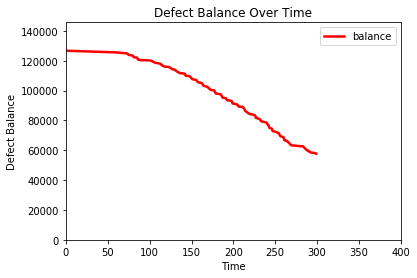

In [59]:
#plot defect balance over time
xdata=df.dateDelta
ydata=df.balance
plt.plot(xdata, ydata, 'r-',linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Defect Balance')
plt.ylim(0, 1.15*startDefectBalance)
plt.xlim(0,400)
plt.legend()
plt.title('Defect Balance Over Time')
plt.show()

#### Plot above appears to follow a curve similar to the function below. Estimate the parameters of that function

$y = b_{0} - \frac{1}{b_{1}}x^2 \ \ \ \ \ \ \ \ \{x>0\}$

In [46]:
#the function above
def func(x, b0, b1):
     return b0-(1/b1)*(x**2)

In [47]:
#function above in terms of x
def getX(y, b0, b1):
    return np.sqrt((y-b0)*-b1)

In [48]:
#derivative of func
def getDerivative(x, b0, b1):
    return -(2/b1)*x

In [49]:
#fiting the curve
popt, pcov = curve_fit(func, xdata, ydata)

In [50]:
xIntercept = getX(0,*popt)

In [51]:
print('b0:',popt[0])
print('b1:',popt[1])

b0: 127324.29772548152
b1: 1.173103014707615


In [52]:
#plot original data
plt.plot(xdata, ydata, 'r-', label='Actual Defect Balance',linewidth=1.75)

In [53]:
#plot modeled curve
MoreDays = pd.Series(np.linspace(300,xIntercept,300),index=np.linspace(300,xIntercept,300))
xPlusMoreDays = xdata.append(MoreDays)
plt.plot(xPlusMoreDays, func(xPlusMoreDays, *popt), 'b-',
         label='Fitted Curve: b0=%5.3f, b1=%5.3f' % tuple(popt),linewidth=2)

In [54]:
#if modeled replacement rate exceeds defined capacity rate (point at which f' exceeds capacity), add the line that extends completion time at that rate
for i in range(0,int(xIntercept)):
    instReplacementRate = getDerivative(i,*popt)
    if instReplacementRate < avgDailyCapacity:
        #print('I cant keep up!!!')
        #print('current replacement rate:', round(instReplacementRate))
        #print('avgDailyCapacity:',round(avgDailyCapacity))
        y_CC = func(i,*popt)
        x_CC = getX(y_CC,*popt)
        slope = instReplacementRate
        yIntercept = y_CC-(slope*x_CC)
        #print('x_CC:',round(x_CC))
        #print('y_CC:',round(y_CC))
        #print('yIntercept: ',round(yIntercept))
        #print('slope: ',round(slope))
        break

#define the line
def capacityConstraint(x,intercept,slope):
    return intercept+(slope*x)

def getXCC(y,intercept,slope):
    return (y-intercept)/slope

xInterceptCC = getXCC(0,yIntercept,slope)

#plot the capacity constraint
x = np.linspace(x_CC,xInterceptCC,xInterceptCC-x_CC)
y = capacityConstraint(x,yIntercept,slope)
plt.plot(x, y, 'g-', label='Capacity Constraint',linewidth=1.75)

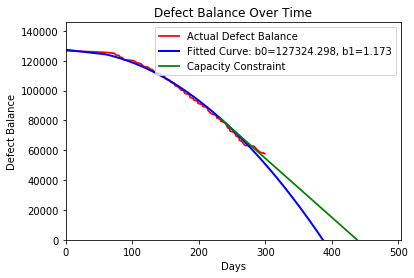

In [55]:
plt.xlabel('Days')
plt.ylabel('Defect Balance')
plt.ylim(0, 1.15*startDefectBalance)
plt.xlim(0, 1.15*max([xIntercept,xInterceptCC]))
plt.legend()
plt.title('Defect Balance Over Time')
plt.show()

In [58]:
def cv_rmse(predicted,actual):
    error = (predicted-actual)**2
    rmse = np.sqrt(error.sum()/error.count())
    per_rmse_pred_ma = rmse/(actual.sum()/actual.count())
    return per_rmse_pred_ma

print('cv_rmse:',cv_rmse(func(xdata,*popt),ydata))

cv_rmse: 0.018654876734425584


In [57]:
#get Min estimated end date (blue curve)
numDaysToEnd = min([getX(0,*popt),xInterceptCC])
estEndDate = str((startDate + datetime.timedelta(numDaysToEnd)).date().strftime('%b %d,%Y'))
print('Min Estimated End Date: ',estEndDate)

#get Max estimated end date (green line)
numDaysToEnd = max([getX(0,*popt),xInterceptCC])
estEndDate = str((startDate + datetime.timedelta(numDaysToEnd)).date().strftime('%b %d,%Y'))
print('Max Estimated End Date: ',estEndDate)

Min Estimated End Date:  Apr 22,2019
Max Estimated End Date:  Jun 12,2019
